# Demo on data preprocessing and postprecessing pipeline

**The purpose of this demo is to show how to use `data_loader` and `postprocessing` function.** Here we use a pretrained Unet as example model.

## Load dependency

In [35]:
import sys

%load_ext autoreload
%autoreload 2
      
sys.path.append('../')

import torch
from dataset import data_loaders, BrainSegmentationDataset
from utils import postprocess_per_volume, dsc_distribution, plot_dsc, gray2rgb, outline
from skimage.io import imsave, imshow
import numpy as np
from matplotlib import pyplot as plt

from models.unet import UNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Use `data_loaders` to get dataloaders for training and validation set

Below we use the default argument. `data_loader()` will automatically load default settings for you. It should take 10-20 minutes to finish loading.



In [3]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

batch_size = 16
epochs = 50
lr = 0.0001
workers = 2
weights = "./"
image_size = 224
aug_scale = 0.05
aug_angle = 15

loader_train, loader_valid = data_loaders(batch_size, workers, image_size, aug_scale, aug_angle, path="../kaggle_3m")

reading train images...
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...
normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


## Load a pretrained Unet

In [4]:

unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
state_dict = torch.load('../weights/unet.pt', map_location=device)
unet.load_state_dict(state_dict)
unet.eval()
unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Evaluate Unet on `loader_vaild`

Important shapes:

x: (16, 3, 224, 224), where 3 is channel number

y_true: (16, 1, 224, 224)

16 is default batch size, which can be manipulated by `batch_size` argument in `data_loaders` function.


**Notice that the range of y_true entry is [0, 255]**, where 0 is background (black), 255 is mask (white, groundtruth)

In [10]:

input_list = []
pred_list = []
true_list = []

for i, data in enumerate(loader_valid):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)
    
    with torch.set_grad_enabled(False):
        y_pred = unet(x)
        y_pred_np = y_pred.detach().cpu().numpy()
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
        y_true_np = y_true.detach().cpu().numpy()
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
        x_np = x.detach().cpu().numpy()
        input_list.extend([x_np[s] for s in range(x_np.shape[0])])


## Postprocess the output

In [18]:
volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
        loader_valid.dataset.patients,
    )

## `volumes` explanation

`volumes` is a dictionary with patient name as key

Each entry is a tuple with size 3. The three entries are original image (`x`), predicted mask (`y_pred`) and true mask (`y_true`) respectively.

In [26]:
print(f"{volumes.keys() = }")
print(f"{volumes['TCGA_HT_7616_19940813'][0].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][1].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][2].shape = }")

volumes.keys() = dict_keys(['TCGA_HT_7616_19940813', 'TCGA_CS_6668_20011025', 'TCGA_CS_4944_20010208', 'TCGA_HT_7879_19981009', 'TCGA_DU_7014_19860618', 'TCGA_DU_6408_19860521', 'TCGA_DU_6404_19850629', 'TCGA_DU_5851_19950428', 'TCGA_CS_6667_20011105', 'TCGA_HT_7692_19960724'])
volumes['TCGA_HT_7616_19940813'][0].shape = (28, 3, 224, 224)
volumes['TCGA_HT_7616_19940813'][1].shape = (28, 1, 224, 224)
volumes['TCGA_HT_7616_19940813'][2].shape = (28, 1, 224, 224)


## Plot outputs

The red outline is the prediction and green outline is groundtruth.

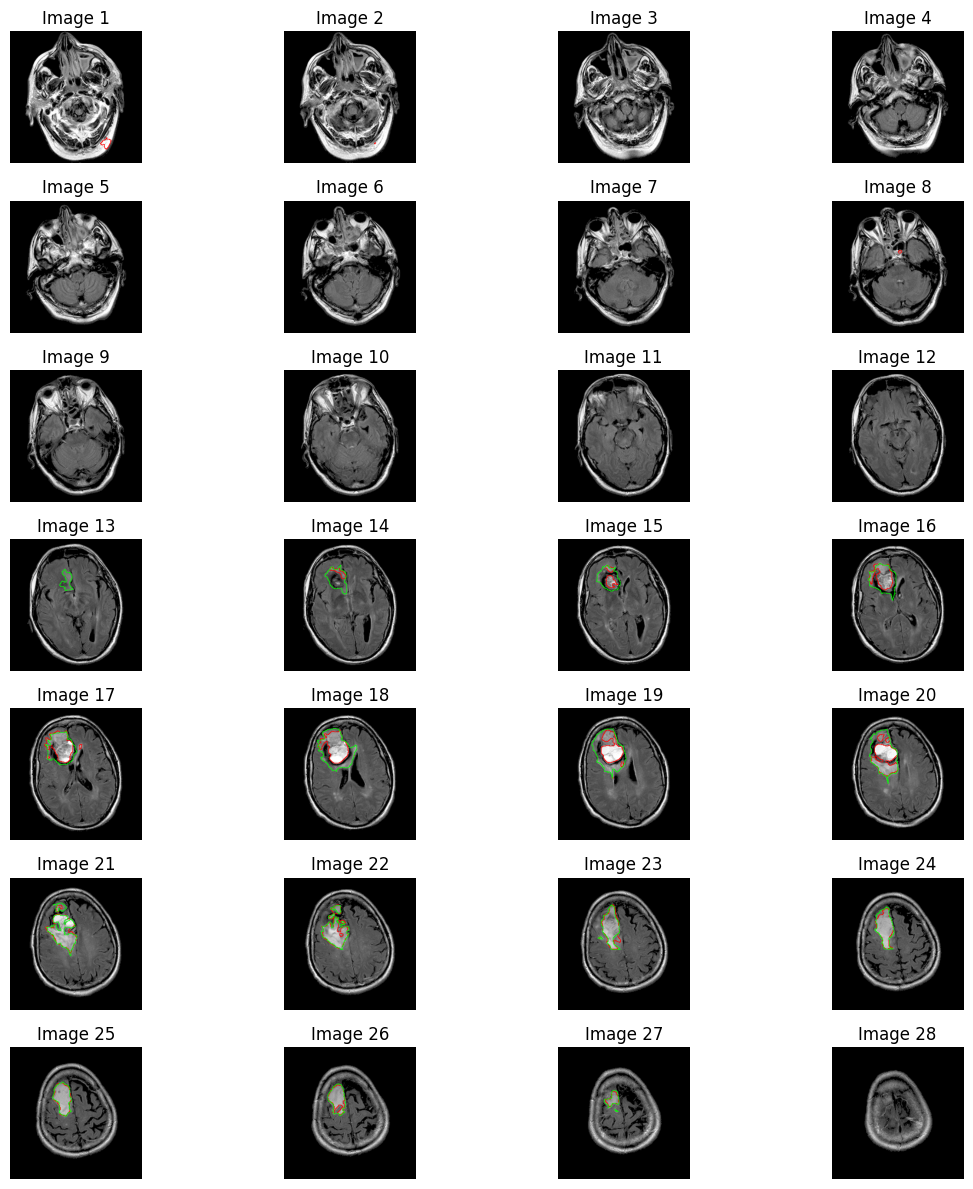

In [40]:
for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    fig, axs = plt.subplots(nrows=int(x.shape[0]/4), ncols=4, figsize=(12, 12))

    for s in range(x.shape[0]):
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0]/255, color=[0, 255, 0])
        axs[int(s/4), s%4].imshow(image)
        axs[int(s/4), s%4].set_title(f"Image {s+1}")
        axs[int(s/4), s%4].axis('off')

    plt.tight_layout()
    plt.show()
    
    break

## plot dsc distribution

`dsc` and `dsc_distribution` are defined in `utils.py`.

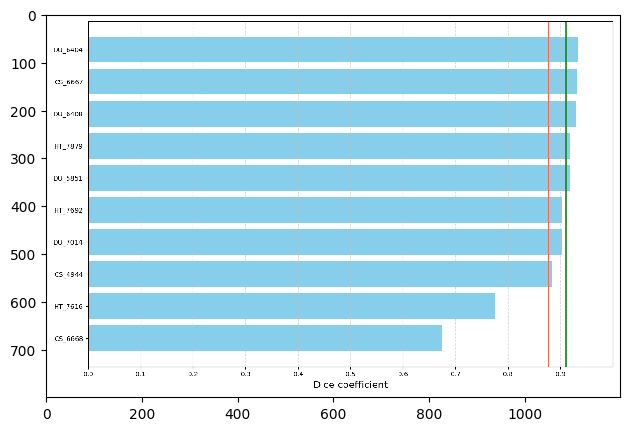

In [41]:
dsc_dist = dsc_distribution(volumes)

dsc_dist_plot = plot_dsc(dsc_dist)

imshow(dsc_dist_plot)

plt.show()